# Pattern Analysis
https://web.ist.utl.pt/rmch/dash/guides/AssociationRuleMining%20in%20Python.html

Association Pattern Analysis

- What are the aisles most purchased together?
- Which aisles are most reordered together?
- Which aisles are most ordered isolately?

ARM Resources
- https://www.kaggle.com/code/datatheque/association-rules-mining-market-basket-analysis/notebook
- https://comum.rcaap.pt/bitstream/10400.26/37552/1/Tese_JoanaOliveira.pdf

# File and libraries

In [1]:
import pandas as pd
import scipy.stats as stats
from mlxtend.frequent_patterns import apriori, association_rules


- apriori method - is used to first identify the most frequent itemsets in the data.
    - How does it work?
        - It takes a dataset of transactions (or a binary dataframe where each column represents an item and each row represents a transaction).
        - It finds frequent itemsets, meaning items that appear together in at least a minimum number of transactions (defined by min_support).

- association_rules - After obtaining frequent itemsets using apriori, you can extract association rules using association_rules.

    - How does it work?
        - It uses the frequent itemsets to generate rules like:
            {A} → {B} (if a customer buys A, there is a high probability they will buy B).
        - It evaluates rule strength using metrics such as:
        -   support → how often the rule appears in the dataset.
        - confidence → how often B is bought when A is bought.
        - lift → whether A and B occur together more often than expected by chance.

***Summary***
- Use Apriori (apriori) to find groups of items frequently bought together.
- Use Association Rules (association_rules) to generate rules like “if customers buy A, they are likely to buy B.”

## DSLabs

In [2]:
%run "scripts/dslabs_functions.py"

dslabs_functions lodaded


# data functions

In [3]:
%run "scripts/data_functions.py"

dslabs_functions lodaded
data_functions lodaded


# Load

In [4]:
import pandas as pd
import numpy as np



#get file from data pre processing notebook. This file has all the column we need to start the data profiling phase
filepath = r'data/citi_bike_pre_proc.csv'

excel_mapping_filepath=r'data/citi_bike_values_encoded_pattern_analysis.xlsx'

file_tag = 'Citi Bike'



In [7]:
test_data = True
# test_data = False

# Load the data
if test_data:
    df = pd.read_csv(filepath, na_values="")

    df: DataFrame = df.sample(frac=0.1, replace = False)

else:
    # If not test_data, load the entire dataset
    df = pd.read_csv(filepath)

id_cols=['ride_id',
         'start_time', 
         'end_time',
         'start_station',
         'end_station',
         'start_station_id',
         'end_station_id',
         'start_lat',
         'start_lng', 
         'hour',
         'end_lat',
         'day_of_month',
         'end_lng',
         'wmo_weather_code',
         'snowfall_cm',
         'ride_duration_sec']
#remove also col = 'snowfall_cm' because it has only 0 values in our dataset
#remove also start_station and end_Station = they have too many unique values(around 2k) which will make the encoding process very slow

# Remove unnecessary columns
df = df.drop(columns=id_cols, axis=1)

df_enc = df.copy()  # DataFrame com as variáveis codificadas

display(df_enc.info())
display(df_enc.shape)


#alterar consoante a necessidade:
#- se quiser considerar a remoçao de outliers, alterar para "df_prep_outl"
#- se nao quiser considerar a remoçao de outliers, alterar para "df_enc"
use_df = "df_enc"  # Pode ser "df_enc" ou "df_prep_outl"
#alterar consoante a necessidade:

#- se quiser considerar a remoçao de outliers, alterar para "df_prep_outl"
#- se nao quiser considerar a remoçao de outliers, alterar para "df_enc"
#use_df_in_scaling = "df_prep_outl_remov_final"  # Pode ser "df_enc" ou "df_prep_outl"
use_df_in_feat_eng = "df_prep_outl"  # Pode ser "df_enc", "df_prep_outl", "df_prep_scal"
use_df_in_pattern = "df_prep_feat"  # Pode ser "df_enc", "df_prep_outl", "df_prep_scal", "df_prep_feat_eng"



<class 'pandas.core.frame.DataFrame'>
Index: 319360 entries, 291527 to 2773263
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bike_type            319360 non-null  object 
 1   user_type            319360 non-null  object 
 2   start_borough        319360 non-null  object 
 3   end_borough          319360 non-null  object 
 4   day_of_week          319360 non-null  object 
 5   is_weekend           319360 non-null  int64  
 6   time_of_day          319360 non-null  object 
 7   ride_duration_min    319360 non-null  float64
 8   temperature_2m       319360 non-null  float64
 9   rain_mm              319360 non-null  float64
 10  cloud_cover_low_pct  319360 non-null  int64  
 11  wind_speed_10m       319360 non-null  float64
 12  wmo_weather_desc     319360 non-null  object 
 13  ride_distance_km     319360 non-null  float64
 14  ride_avg_speed       319360 non-null  float64
dtypes: float64(6), i

None

(319360, 15)

In [8]:
summary = df.describe(include='all')

display(summary)

,bike_type,user_type,start_borough,end_borough,day_of_week,is_weekend,time_of_day,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed
count,319360,319360,319360,319360,319360,319360.000000,319360,319360.000000,319360.000000,319360.000000,319360.000000,319360.000000,319360,319360.000000,319360.000000
unique,2,2,5,6,7,NaN,4,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN
top,electric_bike,member,Manhattan,Manhattan,Monday,NaN,afternoon,NaN,NaN,NaN,NaN,NaN,Overcast,NaN,NaN
freq,209407,260146,201988,201745,57076,NaN,104334,NaN,NaN,NaN,NaN,NaN,137360,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,0.271127,NaN,12.984633,13.084952,0.078783,20.024324,15.413286,NaN,2.009805,11.013313
std,NaN,NaN,NaN,NaN,NaN,0.444542,NaN,20.009211,5.265910,0.364624,34.897904,7.224561,NaN,1.758686,6.115511
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,1.003550,0.600000,0.000000,0.000000,0.800000,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,5.169162,9.100000,0.000000,0.000000,9.800000,NaN,0.841743,8.274242
50%,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,8.968958,12.500000,0.000000,0.000000,14.900000,NaN,1.489346,10.995914
75%,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,15.709400,17.100000,0.000000,20.000000,20.300000,NaN,2.609769,13.847302


In [9]:
display(df_enc.columns)

display(df_enc.shape)

Index(['bike_type', 'user_type', 'start_borough', 'end_borough', 'day_of_week',
       'is_weekend', 'time_of_day', 'ride_duration_min', 'temperature_2m',
       'rain_mm', 'cloud_cover_low_pct', 'wind_speed_10m', 'wmo_weather_desc',
       'ride_distance_km', 'ride_avg_speed'],
      dtype='object')

(319360, 15)

In [56]:
df.head()

,bike_type,user_type,start_borough,end_borough,day_of_week,is_weekend,time_of_day,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed
319091,classic_bike,casual,Brooklyn,Manhattan,Thursday,0,morning,26.045267,6.4,0.0,100,17.9,Overcast,2.562952,5.904224
625839,electric_bike,member,Manhattan,Manhattan,Tuesday,0,afternoon,9.747217,18.4,0.0,0,15.8,Clear sky,1.082359,6.662576
286623,electric_bike,member,Brooklyn,Brooklyn,Monday,0,morning,16.641967,17.9,0.0,0,12.9,Overcast,0.008199,0.029562
2781924,electric_bike,member,Brooklyn,Brooklyn,Tuesday,0,morning,3.034833,6.9,0.7,100,10.3,Drizzle: Moderate,0.828236,16.374587
149011,electric_bike,member,Brooklyn,Brooklyn,Thursday,0,night,2.095800,3.9,0.1,18,11.3,Drizzle: Light,0.484101,13.859165


### Change col time_of_day and day_of_week

In [9]:
#change time_of_day


#change day_of_week

def weekday_group(day_of_week):
    if day_of_week in ['Monday', 'Tuesday']:
        return 'early_week'
    elif day_of_week in ['Wednesday', 'Thursday']:
        return 'mid_week'
    else:  # Friday, Saturday, Sunday
        return 'weekend'

df_enc['weekday_group'] = df_enc['day_of_week'].apply(weekday_group)
df['weekday_group'] = df['day_of_week'].apply(weekday_group)
display(df_enc['weekday_group'].value_counts())

#droping redundant columns that we no longer need
df_enc.drop(columns='day_of_week', inplace=True)
df.drop(columns='day_of_week', inplace=True)

df_enc.drop(columns='is_weekend', inplace=True)
df.drop(columns='is_weekend', inplace=True)

df_enc.drop(columns='hour', inplace=True)
df.drop(columns='hour', inplace=True)

display(df_enc.head())

display(df_enc.shape)
display(df.shape)


weekday_group
weekend       130746
early_week    112024
mid_week       76590
Name: count, dtype: int64

KeyError: "['hour'] not found in axis"

# Data encoding for Pattern mining 

## Encoding Detail

- Ordinal enconding:
  - bike_type
    - 0: classic
    - 1: eletric
  - user_type
    - 0: casual
    - 1: member

- Hierachical encoding: Simbolyic Variables
  - start_station
    - (don't consider for now as the encoding of these variables would be realy dificult because we have 2000 diferente stations)
  - end_station
    - (don't consider for now as the encoding of these variables would be realy dificult because we have 2000 diferente stations)
 

- Cyclical enconding: Simbolyic Variables
  - day_of_week
  - time_of_day
  - hour

- Dummyfication:
  - start_borough
  - end_borough
  - wmo_weather_desc 


- Numeric Values that don't need encoding
  - hour
  - day_of_month
  - is_weekend
  - ride_duration_min
  - temperature_2m
  - rain_mm
  - wmo_weather_code ?????
  - cloud_cover_low_pct
  - wind_speed_10m
  - ride_distance_km
  - ride_avg_speed

Note: week_of_month and day in our case are ordinal variables, and not cyclical, because our dataset only has data for 1 month, nov/19, which means that these two variables don't repeat over time in our dataset.

## Ordinal enconding





In [10]:
from pandas import Series, DataFrame, to_numeric, to_datetime

def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    
    for c in df.columns:
        if 2 == nr_values[c]:  # Colunas com exatamente 2 valores únicos
            variable_types["binary"].append(c)
        else:
            if df[c].dtype == 'datetime64[ns, UTC]':  # Verifica se a coluna já é datetime
                variable_types["date"].append(c)
            else:
                try:
                    df[c] = to_numeric(df[c], errors="raise")
                    variable_types["numeric"].append(c)
                except ValueError:
                    try:
                        df[c] = to_datetime(df[c], errors="raise")
                        variable_types["date"].append(c)
                    except ValueError:
                        variable_types["symbolic"].append(c)

    return variable_types

# Uso da função
variable_types: dict[str, list] = get_variable_types(df)
print(variable_types)

{'numeric': ['ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct', 'wind_speed_10m', 'ride_distance_km', 'ride_avg_speed'], 'binary': ['bike_type', 'user_type', 'is_weekend'], 'date': [], 'symbolic': ['start_borough', 'end_borough', 'day_of_week', 'time_of_day', 'wmo_weather_desc']}


##### bulk Symbolic mapping through Excel

    - Simbolyc
        -...

    - Binary
        - is_weekend
        - bike_type
            - 0: classic
            - 1: eltric
        - user_type
            - 0: classic
            - 1: member

In [11]:


# Generalized function to encode any column based on a mapping dictionary
def encode_column_with_mapping(df, column, mapping_dict, default_value=np.nan):
    """
    Encode a column based on a mapping dictionary.
    
    Args:
    df (pd.DataFrame): The DataFrame containing the column to encode.
    column (str): The column name to encode.
    mapping_dict (dict): Dictionary where keys are the original values and values are the encodings.
    default_value: Value to assign if the key is not found in the mapping dict (default is NaN).
    
    Returns:
    pd.Series: Encoded column.
    """
    return df[column].map(mapping_dict).fillna(default_value)



def sheet_to_dict(excel_file, sheet_name):
    """
    Converts a sheet in an Excel file to a dictionary with the first column as the key and the second as the value.
    
    Args:
    excel_file (str): Path to the Excel file.
    sheet_name (str): Name of the sheet to convert.
    
    Returns:
    dict: A dictionary with keys from the first column and values from the second column.
    """
    # Read the sheet into a DataFrame
    df = pd.read_excel(excel_file, sheet_name=sheet_name)
    
    # Ensure that there are at least two columns
    if df.shape[1] < 2:
        raise ValueError(f"The sheet '{sheet_name}' does not have at least two columns.")
    
    # Create a dictionary from the first and second columns
    mapping_dict = dict(zip(df.iloc[:, 0], df.iloc[:, 1]))
    
    return mapping_dict



In [12]:
excel_file = pd.ExcelFile(excel_mapping_filepath)
sheet_names = excel_file.sheet_names  # List of all sheet names

# Iterate over each sheet and map the corresponding column
for sheet in sheet_names:
    # Assuming the sheet names match the column names in data_enc
    if sheet in df_enc.columns:
        # Load the sheet as a dictionary
        category_mapping = sheet_to_dict(excel_mapping_filepath, sheet)
        
        # Encode the corresponding column in data_enc using the mapping
        df_enc[sheet] = encode_column_with_mapping(df_enc, sheet, category_mapping)
        print(f'{sheet} column encoded')

    else:
        print(f"Warning: No matching column found in data_enc for sheet '{sheet}'")




bike_type column encoded
user_type column encoded


In [13]:
df_enc.head()

,bike_type,user_type,start_borough,end_borough,day_of_month,day_of_week,is_weekend,time_of_day,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed
1451931,1,1,Bronx,Bronx,19,Friday,0,evening,4.517700,9.0,0.0,100,14.0,Overcast,0.006527,0.086682
2834862,1,1,Manhattan,Bronx,30,Tuesday,0,morning,15.494250,13.7,0.0,100,13.2,Overcast,3.985575,15.433757
2319815,1,1,Manhattan,Manhattan,30,Tuesday,0,afternoon,11.757833,19.9,0.0,2,11.3,Overcast,1.243535,6.345737
2383609,1,1,Brooklyn,Manhattan,29,Monday,0,morning,41.535133,23.3,0.0,0,5.7,Overcast,8.411047,12.150264
2127004,0,0,Manhattan,Manhattan,23,Tuesday,0,evening,12.549167,8.7,0.0,0,22.2,Overcast,1.430241,6.838261


In [60]:
display(df_enc['bike_type'].value_counts())
display(df_enc['user_type'].value_counts())


bike_type
1    208951
0    110409
Name: count, dtype: int64

user_type
1    260063
0     59297
Name: count, dtype: int64

In [61]:
for v in variable_types["symbolic"]:
    print(v, df_enc[v].unique())

start_borough ['Brooklyn' 'Manhattan' 'Queens' 'Bronx' 'Staten Island']
end_borough ['Manhattan' 'Brooklyn' 'Queens' 'Bronx' 'Staten Island' 'Jersey City'
 'Hoboken']
day_of_week ['Thursday' 'Tuesday' 'Monday' 'Saturday' 'Wednesday' 'Sunday' 'Friday']
time_of_day ['morning' 'afternoon' 'night' 'evening']
wmo_weather_desc ['Overcast' 'Clear sky' 'Drizzle: Moderate' 'Drizzle: Light'
 'Partly cloudy' 'Mainly clear' 'Rain: Slight' 'Drizzle: Dense'
 'Rain: Moderate']


## Dummyifcation enconding
- Apply dummyification method to the following variables:
    - bike_type
    - user_type
    - start_borough
    - end_borough
    - wmo_weather_desc
    - day_of_week
    - time_of_day
    - user_type
    - bike_type
    - is_weekend


In [13]:
# Apply one-hot encoding to the symbolic variables
df_enc = pd.get_dummies(df, columns=[
    "bike_type",
    "user_type",
    "is_weekend",
    "start_borough",
    "end_borough", 
    "wmo_weather_desc",
    'day_of_week',
    'time_of_day'], dtype=int)


#dropping new columns created with dummyification because we already have is_weekend
#df_enc = df_enc.drop(columns=['day_of_week_Sunday', 'day_of_week_Saturday'], axis=1)
display(df_enc.head())

,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,ride_avg_speed,bike_type_classic_bike,bike_type_electric_bike,user_type_casual,...,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_afternoon,time_of_day_evening,time_of_day_morning,time_of_day_night
291527,22.130200,9.3,0.0,17,27.1,1.835867,4.977452,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1620715,30.473467,9.8,0.0,0,12.8,3.173160,6.247718,1,0,0,...,0,0,1,0,0,0,0,1,0,0
3080788,10.688367,12.9,0.1,16,27.0,1.801181,10.111073,0,1,0,...,0,0,0,1,0,0,0,1,0,0
1826785,5.097900,5.4,1.6,100,27.5,1.597632,18.803417,0,1,0,...,0,0,0,0,0,1,0,0,1,0
2771051,99.111700,13.1,0.0,4,13.8,0.316511,0.191609,1,0,1,...,1,0,0,0,0,0,1,0,0,0


In [17]:
df_enc.shape

(319360, 46)

In [245]:
df_enc.columns

Index(['day_of_month', 'ride_duration_min', 'temperature_2m', 'rain_mm',
       'cloud_cover_low_pct', 'wind_speed_10m', 'ride_distance_km',
       'ride_avg_speed', 'bike_type_classic_bike', 'bike_type_electric_bike',
       'user_type_casual', 'user_type_member', 'is_weekend_0', 'is_weekend_1',
       'start_borough_Bronx', 'start_borough_Brooklyn',
       'start_borough_Jersey City', 'start_borough_Manhattan',
       'start_borough_Queens', 'start_borough_Staten Island',
       'end_borough_Bronx', 'end_borough_Brooklyn', 'end_borough_Jersey City',
       'end_borough_Manhattan', 'end_borough_Queens',
       'end_borough_Staten Island', 'wmo_weather_desc_Clear sky',
       'wmo_weather_desc_Drizzle: Dense', 'wmo_weather_desc_Drizzle: Light',
       'wmo_weather_desc_Drizzle: Moderate', 'wmo_weather_desc_Mainly clear',
       'wmo_weather_desc_Overcast', 'wmo_weather_desc_Partly cloudy',
       'wmo_weather_desc_Rain: Moderate', 'wmo_weather_desc_Rain: Slight',
       'day_of_week_Fr

# Data Preparation for Pattern mining

## Outliers Analysis

### Check distribuition of numeric variable to see if we have outliers with strange values


### Boxplot for Single Variable Values

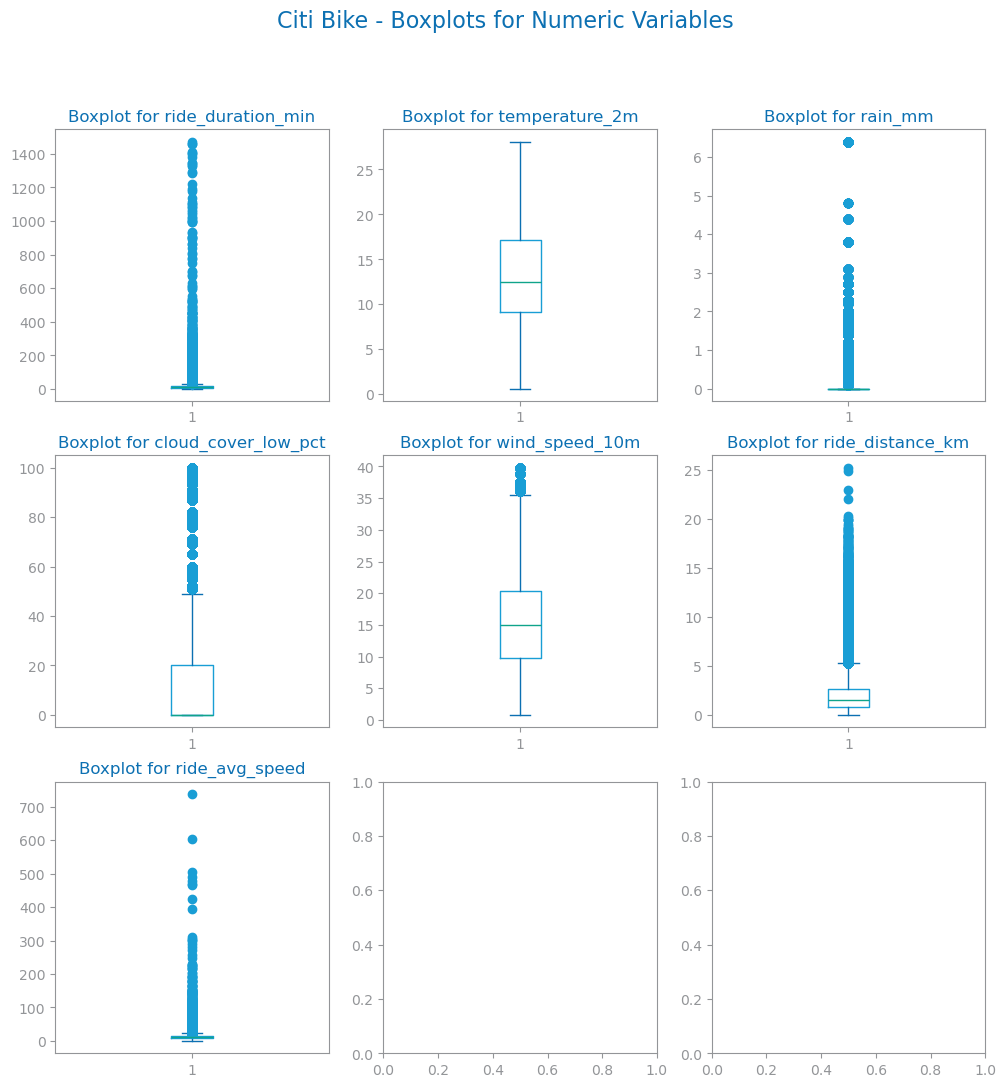

In [14]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT
import pandas as pd

# Obter as variáveis categorizadas pela função get_variable_types
variable_types: dict[str, list] = get_variable_types(df_enc)

# Apenas variáveis numéricas são usadas para os boxplots
numeric = variable_types.get('numeric', [])

# Verificar se a lista de variáveis numéricas não está vazia
if numeric:
    rows, cols = define_grid(len(numeric))  # Definir o número de linhas e colunas com base no número de variáveis
    fig, axs = subplots(rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False)
    fig.suptitle(f"{file_tag} - Boxplots for Numeric Variables", fontsize=16)

    # Iterar sobre as variáveis numéricas e criar os subplots
    i, j = 0, 0
    for n in numeric:
        # Garantir que apenas valores numéricos são passados para boxplot
        data = df_enc[n].dropna().values
        
        if pd.api.types.is_numeric_dtype(df[n]):
            axs[i, j].set_title(f"Boxplot for {n}")
            axs[i, j].boxplot(data)
        
        # Mover para o próximo subplot
        i, j = (i + 1, 0) if (j + 1) % cols == 0 else (i, j + 1)
    #savefig(f"images/{file_tag}_profiling_boxplot_single_num_vars.png")
    # Mostrar os gráficos
    show()
else:
    print("There are no numeric variables.")

#### Analysis of the numeric variable boxplots

- Looking at the numerical variables:
    - ride_distance_km
    - ride_avg_speed
    - wind_speed_10m
    - temperature_2m
    - ride_duration_min

- We can see many outliers in ride_distance_km, with some rides lasting up to 1400 minutes (24 hours). On the CitiBike website, it says members can have 45 minutes and casual users and 30 minutes single rides on a single day(24h), and they will have with extra charges for longer trips. 
    - These outliers are likely users who kept the bike for a full day and paid for the extra time.
    - Since these are probably real cases, we’ll keep them in the dataset for analysis.

- In the case of ride_avg_speed, we have values above 100 km/h, which is not possible. According to the citibike website, we can see that the limit of the citi bikes is 18mph(28,9km/h).
    - These are likely cases where, for some reason, the ride duration is incorrect, with very large values relative to a short distance—probably application errors, or cases where users did not turn off the app and the time continued to count.
    - That said, we will remove these observations from the dataset by limiting it to observations with ride_avg_speed < 30 km/h."

### Drop Outliers

In [15]:
df_prep_outl = df_enc.copy()

In [65]:
df_prep_outl.shape

(319360, 45)

In [16]:
df_prep_outl = df_enc[
    (df_enc['ride_avg_speed'] < 30)
]

display(df_prep_outl.shape)
display(df_prep_outl.head())

(318817, 44)

,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,ride_avg_speed,bike_type_classic_bike,bike_type_electric_bike,user_type_casual,...,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_afternoon,time_of_day_evening,time_of_day_morning,time_of_day_night
291527,22.130200,9.3,0.0,17,27.1,1.835867,4.977452,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1620715,30.473467,9.8,0.0,0,12.8,3.173160,6.247718,1,0,0,...,0,0,1,0,0,0,0,1,0,0
3080788,10.688367,12.9,0.1,16,27.0,1.801181,10.111073,0,1,0,...,0,0,0,1,0,0,0,1,0,0
1826785,5.097900,5.4,1.6,100,27.5,1.597632,18.803417,0,1,0,...,0,0,0,0,0,1,0,0,1,0
2771051,99.111700,13.1,0.0,4,13.8,0.316511,0.191609,1,0,1,...,1,0,0,0,0,0,1,0,0,0


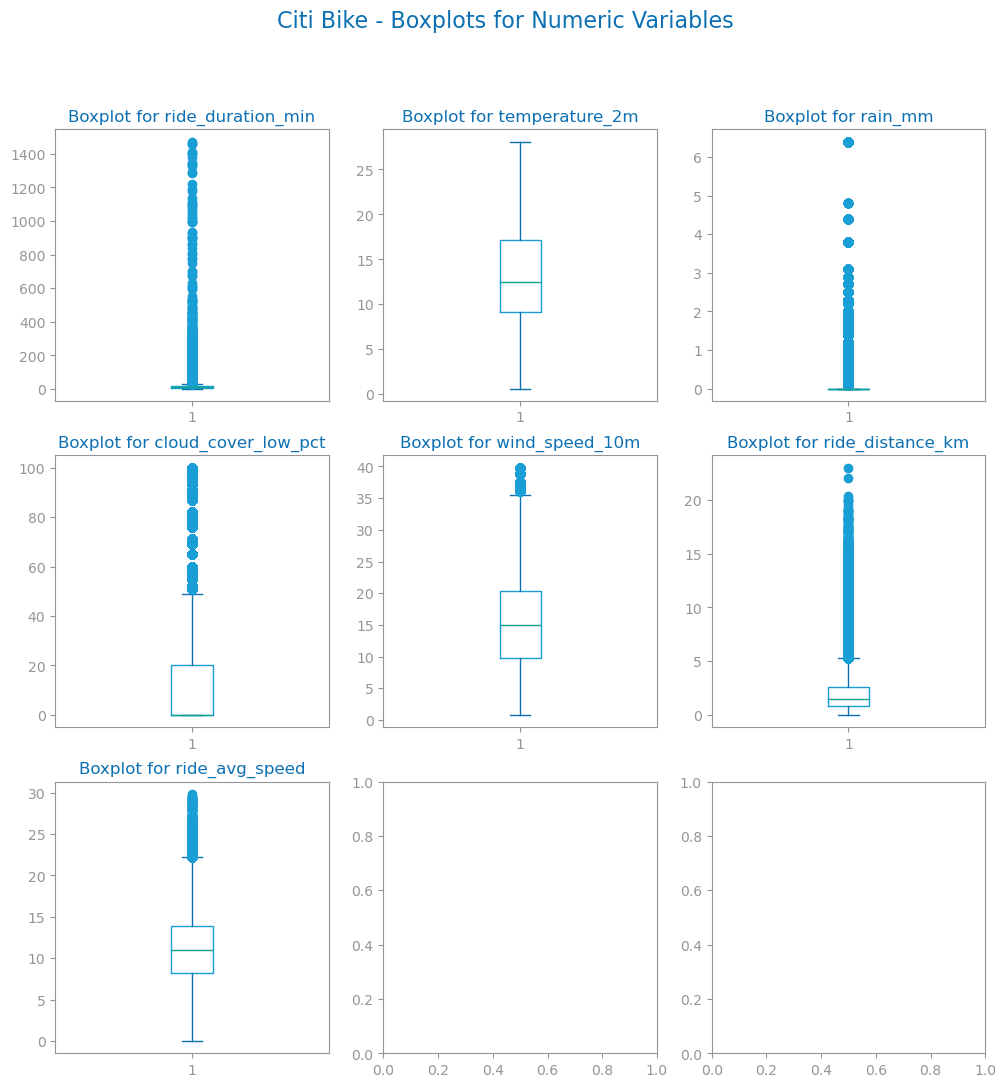

In [17]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT
import pandas as pd

# Obter as variáveis categorizadas pela função get_variable_types
variable_types: dict[str, list] = get_variable_types(df_prep_outl)

# Apenas variáveis numéricas são usadas para os boxplots
numeric = variable_types.get('numeric', [])

# Verificar se a lista de variáveis numéricas não está vazia
if numeric:
    rows, cols = define_grid(len(numeric))  # Definir o número de linhas e colunas com base no número de variáveis
    fig, axs = subplots(rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False)
    fig.suptitle(f"{file_tag} - Boxplots for Numeric Variables", fontsize=16)

    # Iterar sobre as variáveis numéricas e criar os subplots
    i, j = 0, 0
    for n in numeric:
        # Garantir que apenas valores numéricos são passados para boxplot
        data = df_prep_outl[n].dropna().values
        
        if pd.api.types.is_numeric_dtype(df_prep_outl[n]):
            axs[i, j].set_title(f"Boxplot for {n}")
            axs[i, j].boxplot(data)
        
        # Mover para o próximo subplot
        i, j = (i + 1, 0) if (j + 1) % cols == 0 else (i, j + 1)
    #savefig(f"images/{file_tag}_profiling_boxplot_single_num_vars.png")
    # Mostrar os gráficos
    show()
else:
    print("There are no numeric variables.")

In [68]:
df_prep_outl.shape

(318839, 45)

## Feature Selection

In [18]:
#use_df_in_feat_eng="df_prep_outl"
use_df_in_feat_eng="df_prep_outl"

In [20]:
df_prep_outl.shape
use_df_in_feat_eng = "df_prep_outl"

# Escolher o DataFrame a ser utilizado com base na variável 'use_df_in_feat_eng' (feature engineering)
if use_df_in_feat_eng == "df_enc":
    df_to_use_feat = df_enc
elif use_df_in_feat_eng == 'df_prep_outl':
    df_to_use_feat = df_prep_outl
else:
    raise ValueError(f"Invalid DataFrame choice: {use_df_in_feat_eng}. Choose either 'df_enc' or 'df_prep_outl'.")

# Exibir qual DataFrame foi escolhido
print(f"We will use the dataset {use_df_in_feat_eng} dataset, which means that we are {'not ' if use_df_in_feat_eng == 'df_enc' else ''}considering the removal of outliers and also scaled data")
print(f"Shape of dataset: {df_to_use_feat.shape}")


We will use the dataset df_prep_outl dataset, which means that we are considering the removal of outliers and also scaled data
Shape of dataset: (318817, 44)


### Feat 2 - Variance Threshold (Remove Low-Variance Features)


In [25]:
display(df.shape) # original df
display(df_enc.shape) # df after enconding
display(df_prep_outl.shape) # df after enconding and data prep outlier removal

(319360, 16)

(319360, 45)

(318860, 45)

In [21]:
from sklearn.feature_selection import VarianceThreshold

# Remove features with very low variance
selector = VarianceThreshold(threshold=0.1)  # Ajuste o threshold conforme necessário
X_reduced = selector.fit_transform(df_to_use_feat)

# Get selected features
selected_features = df_to_use_feat.columns[selector.get_support()]
print(selected_features)


Index(['ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct',
       'wind_speed_10m', 'ride_distance_km', 'ride_avg_speed',
       'bike_type_classic_bike', 'bike_type_electric_bike', 'user_type_casual',
       'user_type_member', 'is_weekend_0', 'is_weekend_1',
       'start_borough_Brooklyn', 'start_borough_Manhattan',
       'end_borough_Brooklyn', 'end_borough_Manhattan',
       'wmo_weather_desc_Clear sky', 'wmo_weather_desc_Overcast',
       'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday',
       'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday', 'time_of_day_afternoon', 'time_of_day_evening',
       'time_of_day_morning'],
      dtype='object')


In [22]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold


# Print initial features
print("Initial features:\n", df_to_use_feat.columns.tolist())

# Compute variance for each feature
feature_variance = df_to_use_feat.var()
print("\nFeature Variance:\n", feature_variance)

# Define threshold (adjust based on the dataset)
threshold = 0.01
selector = VarianceThreshold(threshold=threshold)

# Fit and transform the dataset
X_reduced = selector.fit_transform(df_to_use_feat)

# Get selected features
initial_features = list(set(df_to_use_feat.columns))
removed_features = list(set(df_to_use_feat.columns) - set(selected_features))
selected_features = df_to_use_feat.columns[selector.get_support()]


# Print results
print("Initial Features df_prep:\n", initial_features)
print("\nRemoved Features (low variance < {:.3f}):\n".format(threshold), removed_features)
print("\nFinal Features list:\n", selected_features.tolist())


Initial features:
 ['ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct', 'wind_speed_10m', 'ride_distance_km', 'ride_avg_speed', 'bike_type_classic_bike', 'bike_type_electric_bike', 'user_type_casual', 'user_type_member', 'is_weekend_0', 'is_weekend_1', 'start_borough_Bronx', 'start_borough_Brooklyn', 'start_borough_Manhattan', 'start_borough_Queens', 'start_borough_Staten Island', 'end_borough_Bronx', 'end_borough_Brooklyn', 'end_borough_Jersey City', 'end_borough_Manhattan', 'end_borough_Queens', 'end_borough_Staten Island', 'wmo_weather_desc_Clear sky', 'wmo_weather_desc_Drizzle: Dense', 'wmo_weather_desc_Drizzle: Light', 'wmo_weather_desc_Drizzle: Moderate', 'wmo_weather_desc_Mainly clear', 'wmo_weather_desc_Overcast', 'wmo_weather_desc_Partly cloudy', 'wmo_weather_desc_Rain: Moderate', 'wmo_weather_desc_Rain: Slight', 'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_

In [25]:
selected_features

Index(['ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct',
       'wind_speed_10m', 'ride_distance_km', 'ride_avg_speed',
       'bike_type_classic_bike', 'bike_type_electric_bike', 'user_type_casual',
       'user_type_member', 'is_weekend_0', 'is_weekend_1',
       'start_borough_Bronx', 'start_borough_Brooklyn',
       'start_borough_Manhattan', 'start_borough_Queens', 'end_borough_Bronx',
       'end_borough_Brooklyn', 'end_borough_Manhattan', 'end_borough_Queens',
       'wmo_weather_desc_Clear sky', 'wmo_weather_desc_Drizzle: Light',
       'wmo_weather_desc_Drizzle: Moderate', 'wmo_weather_desc_Mainly clear',
       'wmo_weather_desc_Overcast', 'wmo_weather_desc_Partly cloudy',
       'wmo_weather_desc_Rain: Slight', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday',
       'time_of_day_afternoon', 'time_of_day_evening', 'time_of_day_m

In [26]:
df_prep_feat_var = df_to_use_feat[selected_features]

In [27]:
df_prep_feat_var.shape

(318817, 39)

In [28]:
display(df_enc.shape) # df after enconding
display(df_prep_outl.shape) # df after enconding and data prep outlier removal
display(df_to_use_feat.shape) # df after enconding and data prep outlier removal
display(df_prep_feat_var.shape) 

(319360, 44)

(318817, 44)

(318817, 44)

(318817, 39)

### Feat 3 - Drop Redundant Variables
    - Correlation interpretation - values between [-1,1]:
        - 0.9 and above: Very strong correlation (typically, > 0.9 is considered almost perfect).
        - 0.7 to 0.9: Strong correlation.
        - 0.3 to 0.7: Moderate correlation.
        - 0.1 to 0.3: Weak correlation.
        - 0 to 0.1: No significant correlation.       

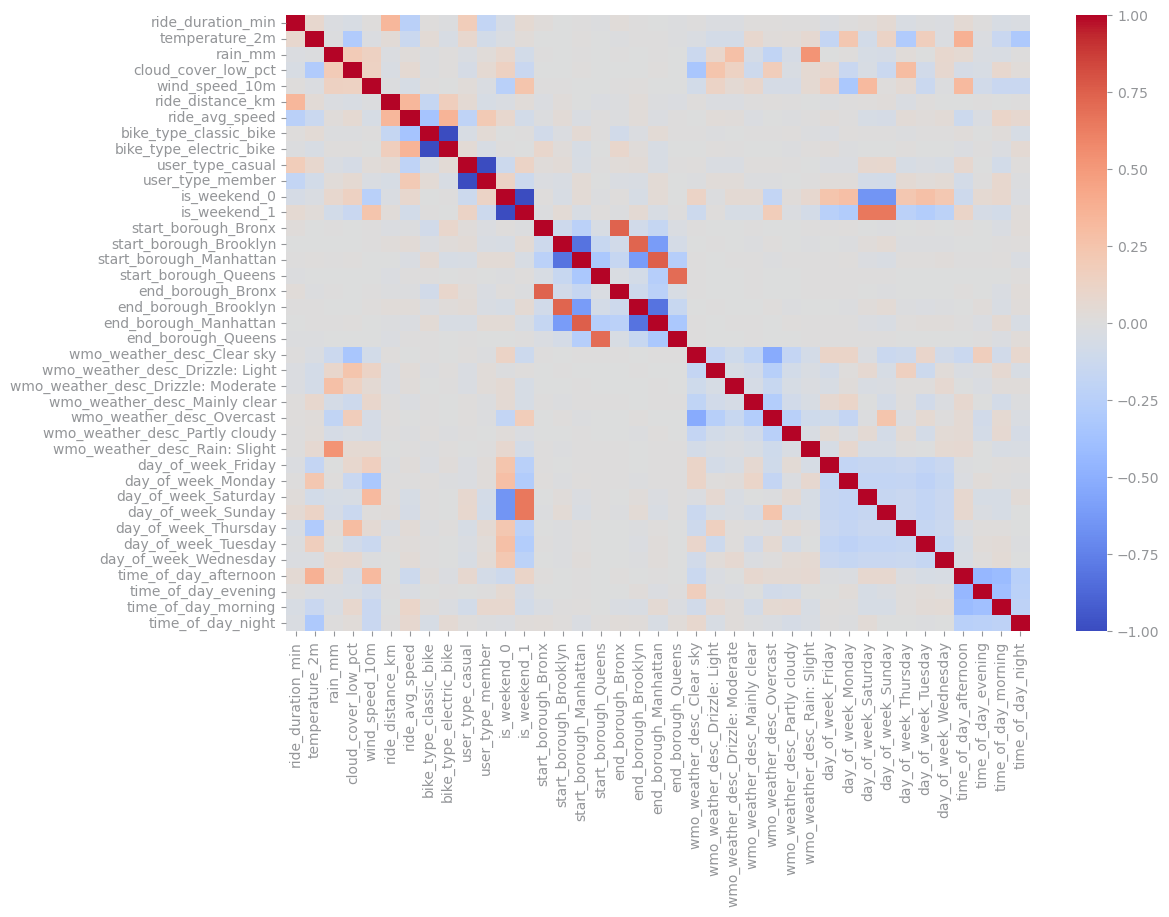

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = df_prep_feat_var.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.show()

In [30]:
import numpy as np

# Calculate correlation matrix
corr_matrix = df_prep_feat_var.corr()

# Identify pairs of highly correlated features (correlation > 0.8)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Initialize an empty list to store the pairs of highly correlated features
redundant_pairs = []

# Loop through each column to find pairs with correlation > 0.8
for column in upper_tri.columns:
    for row in upper_tri.index:
        if upper_tri.loc[row, column] > 0.8:
            redundant_pairs.append((row, column, upper_tri.loc[row, column]))

# Print initial features count
print(f"Initial number of features: {len(df_prep_feat_var.columns)}")

# Print redundant pairs
print(f"Redundant pairs (correlation > 0.8):")
for pair in redundant_pairs:
    print(f"{pair[0]} and {pair[1]}: Correlation = {pair[2]}")

# Identify the features to drop based on redundancy
to_drop = [pair[1] for pair in redundant_pairs]

# Print features that will be dropped
print(f"Number of features dropped: {len(to_drop)}")
print(f"Features dropped: {to_drop}")

# Drop the correlated features
df_prep_final = df_prep_feat_var.drop(columns=to_drop)

# Print remaining features count
print(f"Remaining features: {len(df_prep_final.columns)}")
print(f"Remaining features: {df_prep_final.columns.tolist()}")


Initial number of features: 39
Redundant pairs (correlation > 0.8):
Number of features dropped: 0
Features dropped: []
Remaining features: 39
Remaining features: ['ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct', 'wind_speed_10m', 'ride_distance_km', 'ride_avg_speed', 'bike_type_classic_bike', 'bike_type_electric_bike', 'user_type_casual', 'user_type_member', 'is_weekend_0', 'is_weekend_1', 'start_borough_Bronx', 'start_borough_Brooklyn', 'start_borough_Manhattan', 'start_borough_Queens', 'end_borough_Bronx', 'end_borough_Brooklyn', 'end_borough_Manhattan', 'end_borough_Queens', 'wmo_weather_desc_Clear sky', 'wmo_weather_desc_Drizzle: Light', 'wmo_weather_desc_Drizzle: Moderate', 'wmo_weather_desc_Mainly clear', 'wmo_weather_desc_Overcast', 'wmo_weather_desc_Partly cloudy', 'wmo_weather_desc_Rain: Slight', 'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday

In [84]:
display(df.shape) # original df
display(df_enc.shape) # df after enconding
display(df_prep_outl.shape) # df after enconding and data prep outlier removal
display(df_prep_feat_var.shape) 
display(df_prep_final.shape) 

(319360, 15)

(319360, 45)

(318839, 45)

(318839, 39)

(318839, 39)

## Discritization of the numerical variable

In [31]:
df_prep_feat_var.head()

,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,ride_avg_speed,bike_type_classic_bike,bike_type_electric_bike,user_type_casual,...,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_afternoon,time_of_day_evening,time_of_day_morning,time_of_day_night
291527,22.130200,9.3,0.0,17,27.1,1.835867,4.977452,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1620715,30.473467,9.8,0.0,0,12.8,3.173160,6.247718,1,0,0,...,0,0,1,0,0,0,0,1,0,0
3080788,10.688367,12.9,0.1,16,27.0,1.801181,10.111073,0,1,0,...,0,0,0,1,0,0,0,1,0,0
1826785,5.097900,5.4,1.6,100,27.5,1.597632,18.803417,0,1,0,...,0,0,0,0,0,1,0,0,1,0
2771051,99.111700,13.1,0.0,4,13.8,0.316511,0.191609,1,0,1,...,1,0,0,0,0,0,1,0,0,0


In [32]:
use_df_in_discrit = "df_prep_feat_var"

In [34]:
# Escolher o DataFrame a ser utilizado com base na variável 'use_df_in_discrit' (clustering)
if use_df_in_discrit == "df_enc":
    df_to_use_discrit = df_enc
elif use_df_in_discrit == "df_prep_outl":
    df_to_use_discrit = df_prep_outl
elif use_df_in_discrit == "df_prep_feat_var":
    df_to_use_discrit = df_prep_feat_var
else:
    raise ValueError(f"Invalid DataFrame choice: {use_df_in_discrit}. Choose either 'df_enc', 'df_prep_outl', or 'df_prep_feat_var'.")

# Exibir qual DataFrame foi escolhido
print(f"We will use the dataset {use_df_in_discrit} dataset")
print(f"Shape of dataset: {df_to_use_discrit.shape}")


We will use the dataset df_prep_feat_var dataset
Shape of dataset: (318817, 39)


### Apply cut to discretize the numeric variables that follows a normal distribution
    - On this method we don't need to define the limits for each bin, cut will define them and distribute the values by the bins with the same lenght

In [35]:
# Don't consider binary variables, because these are already encoded (0 or 1)
binary_var = [col for col in df_to_use_discrit.columns if df_to_use_discrit[col].nunique() == 2]

# List of columns to apply the cut transformation
columns_to_bin = df_to_use_discrit.drop(columns=binary_var, axis=1).columns

# Apply pd.cut to all selected numerical columns
bins_dict = {}  # To store bin edges for each variable

for v in columns_to_bin:
    df_to_use_discrit[v], bins = pd.cut(df_to_use_discrit[v], bins=3, labels=['low', 'medium', 'high'], retbins=True)
    bins_dict[v] = bins  # Store bin limits for each variable

# Print bin limits for reference
for col, bins in bins_dict.items():
    print(f"Limits for {col}: {bins}")

# Check the results
display(df_to_use_discrit[columns_to_bin].apply(pd.Series.value_counts))


Limits for ride_duration_min: [-4.68139617e-01  4.91566756e+02  9.82129961e+02  1.47269317e+03]
Limits for temperature_2m: [ 0.5725      9.76666667 18.93333333 28.1       ]
Limits for rain_mm: [-0.0064      2.13333333  4.26666667  6.4       ]
Limits for cloud_cover_low_pct: [ -0.1         33.33333333  66.66666667 100.        ]
Limits for wind_speed_10m: [ 0.761 13.8   26.8   39.8  ]
Limits for ride_distance_km: [-0.02299427  7.66475618 15.32951235 22.99426853]
Limits for ride_avg_speed: [-0.02985642  9.95213939 19.90427878 29.85641817]


,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,ride_avg_speed
low,318754,99957,317444,254133,145697,314079,127363
medium,32,167506,874,15409,146394,4648,185827
high,31,51354,499,49275,26726,90,5627


In [36]:
display(df_to_use_discrit.head())

,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,ride_avg_speed,bike_type_classic_bike,bike_type_electric_bike,user_type_casual,...,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_afternoon,time_of_day_evening,time_of_day_morning,time_of_day_night
291527,low,low,low,low,high,low,low,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1620715,low,medium,low,low,low,low,low,1,0,0,...,0,0,1,0,0,0,0,1,0,0
3080788,low,medium,low,low,high,low,medium,0,1,0,...,0,0,0,1,0,0,0,1,0,0
1826785,low,low,low,high,high,low,medium,0,1,0,...,0,0,0,0,0,1,0,0,1,0
2771051,low,medium,low,low,low,low,low,1,0,1,...,1,0,0,0,0,0,1,0,0,0


In [92]:
df_to_use_discrit.columns

Index(['ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct',
       'wind_speed_10m', 'ride_distance_km', 'ride_avg_speed',
       'bike_type_classic_bike', 'bike_type_electric_bike', 'user_type_casual',
       'user_type_member', 'is_weekend_0', 'is_weekend_1',
       'start_borough_Bronx', 'start_borough_Brooklyn',
       'start_borough_Manhattan', 'start_borough_Queens', 'end_borough_Bronx',
       'end_borough_Brooklyn', 'end_borough_Manhattan', 'end_borough_Queens',
       'wmo_weather_desc_Clear sky', 'wmo_weather_desc_Drizzle: Light',
       'wmo_weather_desc_Drizzle: Moderate', 'wmo_weather_desc_Mainly clear',
       'wmo_weather_desc_Overcast', 'wmo_weather_desc_Partly cloudy',
       'wmo_weather_desc_Rain: Slight', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday',
       'time_of_day_afternoon', 'time_of_day_evening', 'time_of_day_m

## Dummyification of remaining variables

In [37]:
import pandas as pd

# Identificar automaticamente variáveis categóricas (excluindo numéricas)
categorical_cols = df_to_use_discrit.select_dtypes(exclude=['number']).columns.tolist()

# Aplicar one-hot encoding a todas as variáveis categóricas
df_dummy = pd.get_dummies(df_to_use_discrit[categorical_cols]).astype(int)

# Criar dataset final sem as colunas originais categóricas
df_discrit_final = df_to_use_discrit.drop(columns=categorical_cols).join(df_dummy)

# Verificar resultado
display(df_to_use_discrit.head())        # Mostrar o dataset original
display(df_to_use_discrit.shape)         # Ver o tamanho do dataset original

display(df_discrit_final.head())  # Mostrar o dataset final com as variáveis dummies
display(df_discrit_final.shape)   # Ver o tamanho do dataset final

display(df_discrit_final.columns)  # Ver as colunas do dataset final


,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,ride_avg_speed,bike_type_classic_bike,bike_type_electric_bike,user_type_casual,...,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_afternoon,time_of_day_evening,time_of_day_morning,time_of_day_night
291527,low,low,low,low,high,low,low,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1620715,low,medium,low,low,low,low,low,1,0,0,...,0,0,1,0,0,0,0,1,0,0
3080788,low,medium,low,low,high,low,medium,0,1,0,...,0,0,0,1,0,0,0,1,0,0
1826785,low,low,low,high,high,low,medium,0,1,0,...,0,0,0,0,0,1,0,0,1,0
2771051,low,medium,low,low,low,low,low,1,0,1,...,1,0,0,0,0,0,1,0,0,0


(318817, 39)

,bike_type_classic_bike,bike_type_electric_bike,user_type_casual,user_type_member,is_weekend_0,is_weekend_1,start_borough_Bronx,start_borough_Brooklyn,start_borough_Manhattan,start_borough_Queens,...,cloud_cover_low_pct_high,wind_speed_10m_low,wind_speed_10m_medium,wind_speed_10m_high,ride_distance_km_low,ride_distance_km_medium,ride_distance_km_high,ride_avg_speed_low,ride_avg_speed_medium,ride_avg_speed_high
291527,0,1,0,1,1,0,0,1,0,0,...,0,0,0,1,1,0,0,1,0,0
1620715,1,0,0,1,0,1,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0
3080788,0,1,0,1,1,0,1,0,0,0,...,0,0,0,1,1,0,0,0,1,0
1826785,0,1,0,1,1,0,0,1,0,0,...,1,0,0,1,1,0,0,0,1,0
2771051,1,0,1,0,1,0,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0


(318817, 53)

Index(['bike_type_classic_bike', 'bike_type_electric_bike', 'user_type_casual',
       'user_type_member', 'is_weekend_0', 'is_weekend_1',
       'start_borough_Bronx', 'start_borough_Brooklyn',
       'start_borough_Manhattan', 'start_borough_Queens', 'end_borough_Bronx',
       'end_borough_Brooklyn', 'end_borough_Manhattan', 'end_borough_Queens',
       'wmo_weather_desc_Clear sky', 'wmo_weather_desc_Drizzle: Light',
       'wmo_weather_desc_Drizzle: Moderate', 'wmo_weather_desc_Mainly clear',
       'wmo_weather_desc_Overcast', 'wmo_weather_desc_Partly cloudy',
       'wmo_weather_desc_Rain: Slight', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday',
       'time_of_day_afternoon', 'time_of_day_evening', 'time_of_day_morning',
       'time_of_day_night', 'ride_duration_min_low',
       'ride_duration_min_medium', 'ride_duration_min_high',
       'temperature_

In [97]:

display(df_discrit_final.head())  # Mostrar o dataset final com as variáveis dummies
display(df_discrit_final.shape)   # Ver o tamanho do dataset final

display(df_discrit_final.columns)  # Ver as colunas do dataset final

,bike_type_classic_bike,bike_type_electric_bike,user_type_casual,user_type_member,is_weekend_0,is_weekend_1,start_borough_Bronx,start_borough_Brooklyn,start_borough_Manhattan,start_borough_Queens,...,cloud_cover_low_pct_high,wind_speed_10m_low,wind_speed_10m_medium,wind_speed_10m_high,ride_distance_km_low,ride_distance_km_medium,ride_distance_km_high,ride_avg_speed_low,ride_avg_speed_medium,ride_avg_speed_high
319091,1,0,1,0,1,0,0,1,0,0,...,1,0,1,0,1,0,0,1,0,0
625839,0,1,0,1,1,0,0,0,1,0,...,0,0,1,0,1,0,0,1,0,0
286623,0,1,0,1,1,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
2781924,0,1,0,1,1,0,0,1,0,0,...,1,1,0,0,1,0,0,0,1,0
149011,0,1,0,1,1,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0


(318839, 53)

Index(['bike_type_classic_bike', 'bike_type_electric_bike', 'user_type_casual',
       'user_type_member', 'is_weekend_0', 'is_weekend_1',
       'start_borough_Bronx', 'start_borough_Brooklyn',
       'start_borough_Manhattan', 'start_borough_Queens', 'end_borough_Bronx',
       'end_borough_Brooklyn', 'end_borough_Manhattan', 'end_borough_Queens',
       'wmo_weather_desc_Clear sky', 'wmo_weather_desc_Drizzle: Light',
       'wmo_weather_desc_Drizzle: Moderate', 'wmo_weather_desc_Mainly clear',
       'wmo_weather_desc_Overcast', 'wmo_weather_desc_Partly cloudy',
       'wmo_weather_desc_Rain: Slight', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday',
       'time_of_day_afternoon', 'time_of_day_evening', 'time_of_day_morning',
       'time_of_day_night', 'ride_duration_min_low',
       'ride_duration_min_medium', 'ride_duration_min_high',
       'temperature_

# Pattern mining application

In [38]:
df_discrit_final.head()

,bike_type_classic_bike,bike_type_electric_bike,user_type_casual,user_type_member,is_weekend_0,is_weekend_1,start_borough_Bronx,start_borough_Brooklyn,start_borough_Manhattan,start_borough_Queens,...,cloud_cover_low_pct_high,wind_speed_10m_low,wind_speed_10m_medium,wind_speed_10m_high,ride_distance_km_low,ride_distance_km_medium,ride_distance_km_high,ride_avg_speed_low,ride_avg_speed_medium,ride_avg_speed_high
291527,0,1,0,1,1,0,0,1,0,0,...,0,0,0,1,1,0,0,1,0,0
1620715,1,0,0,1,0,1,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0
3080788,0,1,0,1,1,0,1,0,0,0,...,0,0,0,1,1,0,0,0,1,0
1826785,0,1,0,1,1,0,0,1,0,0,...,1,0,0,1,1,0,0,0,1,0
2771051,1,0,1,0,1,0,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0


In [39]:
print(df_discrit_final.columns)


Index(['bike_type_classic_bike', 'bike_type_electric_bike', 'user_type_casual',
       'user_type_member', 'is_weekend_0', 'is_weekend_1',
       'start_borough_Bronx', 'start_borough_Brooklyn',
       'start_borough_Manhattan', 'start_borough_Queens', 'end_borough_Bronx',
       'end_borough_Brooklyn', 'end_borough_Manhattan', 'end_borough_Queens',
       'wmo_weather_desc_Clear sky', 'wmo_weather_desc_Drizzle: Light',
       'wmo_weather_desc_Drizzle: Moderate', 'wmo_weather_desc_Mainly clear',
       'wmo_weather_desc_Overcast', 'wmo_weather_desc_Partly cloudy',
       'wmo_weather_desc_Rain: Slight', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday',
       'time_of_day_afternoon', 'time_of_day_evening', 'time_of_day_morning',
       'time_of_day_night', 'ride_duration_min_low',
       'ride_duration_min_medium', 'ride_duration_min_high',
       'temperature_

## Parameterizable pattern discovery



In [101]:
df_discrit_final.columns

Index(['bike_type_classic_bike', 'bike_type_electric_bike', 'user_type_casual',
       'user_type_member', 'is_weekend_0', 'is_weekend_1',
       'start_borough_Bronx', 'start_borough_Brooklyn',
       'start_borough_Manhattan', 'start_borough_Queens', 'end_borough_Bronx',
       'end_borough_Brooklyn', 'end_borough_Manhattan', 'end_borough_Queens',
       'wmo_weather_desc_Clear sky', 'wmo_weather_desc_Drizzle: Light',
       'wmo_weather_desc_Drizzle: Moderate', 'wmo_weather_desc_Mainly clear',
       'wmo_weather_desc_Overcast', 'wmo_weather_desc_Partly cloudy',
       'wmo_weather_desc_Rain: Slight', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday',
       'time_of_day_afternoon', 'time_of_day_evening', 'time_of_day_morning',
       'time_of_day_night', 'ride_duration_min_low',
       'ride_duration_min_medium', 'ride_duration_min_high',
       'temperature_

In [40]:
# Remove colunas que contém "rain" no nome e a coluna "wmo_weather_desc"
#df_discrit_final = df_discrit_final.loc[:, ~df_discrit_final.columns.str.contains('rain')]
df_discrit_final = df_discrit_final.loc[:, ~df_discrit_final.columns.str.contains('wmo')]
df_discrit_final = df_discrit_final.loc[:, ~df_discrit_final.columns.str.contains('borough')]

# Verifica as colunas restantes
df_discrit_final.columns


Index(['bike_type_classic_bike', 'bike_type_electric_bike', 'user_type_casual',
       'user_type_member', 'is_weekend_0', 'is_weekend_1',
       'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday',
       'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday', 'time_of_day_afternoon', 'time_of_day_evening',
       'time_of_day_morning', 'time_of_day_night', 'ride_duration_min_low',
       'ride_duration_min_medium', 'ride_duration_min_high',
       'temperature_2m_low', 'temperature_2m_medium', 'temperature_2m_high',
       'rain_mm_low', 'rain_mm_medium', 'rain_mm_high',
       'cloud_cover_low_pct_low', 'cloud_cover_low_pct_medium',
       'cloud_cover_low_pct_high', 'wind_speed_10m_low',
       'wind_speed_10m_medium', 'wind_speed_10m_high', 'ride_distance_km_low',
       'ride_distance_km_medium', 'ride_distance_km_high',
       'ride_avg_speed_low', 'ride_avg_speed_medium', 'ride_avg_speed_high'],
      dtype='object')

In [41]:
from scipy.stats import binom
N = len(df_discrit_final)
probs = {col : df_discrit_final[[col]].eq(1).sum()[col]/N for col in df_discrit_final.columns}

def add_significance(patterns):
    patterns['significance'] = 0.0
    for i, pattern in patterns.iterrows():
        prob = 1
        for item in pattern['itemsets']: prob = prob * probs[item]
        patterns.at[i,'significance'] = 1-binom.cdf(pattern['support']*N-1, N, prob)

In [42]:
def find_patterns(mine_rules=True, min_patterns=10, min_length=4, max_pvalue=0.1, min_support=0.6, min_confidence=0.8, min_lift=1.4):
    patterns = {}
    min_support = 1
    while min_support>0:
    
        min_support = min_support*0.9
        print("Finding patterns with min sup %f"%min_support)
        patterns = apriori(df_discrit_final, min_support=min_support, use_colnames=True)
    
        if mine_rules and len(patterns)>0:
            patterns = association_rules(patterns, metric="lift", min_threshold=min_lift)
            patterns = patterns[['antecedents','consequents','support','confidence','lift']]
            patterns = patterns[(patterns['confidence'] >= min_confidence)]
            patterns['itemsets'] = [x | y for x, y in zip(patterns['antecedents'], patterns['consequents'])]
        
        patterns['length'] = patterns['itemsets'].apply(lambda x: len(x))
        patterns = patterns[(patterns['length'] >= min_length)]
        add_significance(patterns)
        patterns = patterns[(patterns['significance'] <= max_pvalue)]
            
        if len(patterns) >= min_patterns: break
    
    print("Number of found patterns:",len(patterns))
    return patterns

### find patterns inesperadamente frequentes

- using max of p_value=0.01 (1%)
    - This way we make sure we only consider patterns that have relevent statistic significance (most likely they are not random) 

In [115]:
#df_discrit_final.drop(columns='end_borough', inplace=True)

df_freq_patterns = find_patterns(
    mine_rules = False,
    min_patterns = 150, 
    min_length = 3, 
    max_pvalue = 0.05, 
    min_support=0.10
)
# Exportando para CSV novamente
df_freq_patterns.to_csv('data/citi_bike_freq_patterns.csv', sep=';',index=False)

df_freq_patterns

Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420
Finding patterns with min sup 0.348678
Finding patterns with min sup 0.313811
Finding patterns with min sup 0.282430
Number of found patterns: 199


,support,itemsets,length,significance
84,0.290557,"(bike_type_classic_bike, user_type_member, rid...",3,0.000000
85,0.289478,"(rain_mm_low, bike_type_classic_bike, user_typ...",3,0.000000
86,0.289472,"(ride_distance_km_low, bike_type_classic_bike,...",3,0.000000
88,0.344650,"(ride_distance_km_low, bike_type_classic_bike,...",3,0.005989
89,0.343528,"(ride_distance_km_low, bike_type_classic_bike,...",3,0.001918
...,...,...,...,...
475,0.383824,"(cloud_cover_low_pct_low, ride_duration_min_lo...",6,0.000000
477,0.303137,"(cloud_cover_low_pct_low, is_weekend_0, ride_d...",6,0.000000
480,0.288324,"(is_weekend_0, bike_type_electric_bike, ride_d...",7,0.000000
481,0.294196,"(cloud_cover_low_pct_low, ride_duration_min_lo...",7,0.000000


### find patterns inesperadamente discriminativos

In [116]:
# Supondo que você tenha um DataFrame de padrões
df_patterns = find_patterns(min_support=0.2, max_pvalue=0.05, min_patterns=100, min_confidence=0.8, min_lift=1.4)

# Convertendo o frozenset em uma string para melhor exportação
df_patterns['antecedents'] = df_patterns['antecedents'].apply(lambda x: ', '.join(map(str, list(x))) if isinstance(x, frozenset) else str(x))
df_patterns['consequents'] = df_patterns['consequents'].apply(lambda x: ', '.join(map(str, list(x))) if isinstance(x, frozenset) else str(x))
df_patterns['itemsets'] = df_patterns['itemsets'].apply(lambda x: ', '.join(map(str, list(x))) if isinstance(x, frozenset) else str(x))

# Exportando para CSV novamente
df_patterns.to_csv('data/citi_bike_discr_patterns.csv', sep=';',index=False)

df_patterns


Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420
Finding patterns with min sup 0.348678
Finding patterns with min sup 0.313811
Finding patterns with min sup 0.282430
Finding patterns with min sup 0.254187
Finding patterns with min sup 0.228768
Finding patterns with min sup 0.205891
Finding patterns with min sup 0.185302
Finding patterns with min sup 0.166772


KeyboardInterrupt: 

# Pattern mining: Members vs casual riders

In [43]:
# Comparando os padrões de "usuários membros" e "não membros"

df_members = df_discrit_final[df_discrit_final['user_type_member'] == 1]
df_members.drop(columns='user_type_member', inplace=True)
# Drop columns that contain 'start_borough' in their names
df_members = df_members.drop(columns=[col for col in df_members.columns if 'start_borough' in col])
df_members = df_members.drop(columns=[col for col in df_members.columns if 'end_borough' in col])


df_casual = df_discrit_final[df_discrit_final['user_type_member'] == 0]
df_casual.drop(columns='user_type_casual', inplace=True)
df_casual = df_casual.drop(columns=[col for col in df_casual.columns if 'start_borough' in col])
df_casual = df_casual.drop(columns=[col for col in df_casual.columns if 'end_borough' in col])



In [44]:
display(df_members.shape)
display(df_casual.shape)

(259685, 37)

(59132, 37)

In [45]:
from IPython.display import display  # Para exibir tabelas no Jupyter Notebook
import pandas as pd

def find_patterns(df, mine_rules=True, min_patterns=10, min_length=4, max_pvalue=0.1, min_support=0.6, min_confidence=0.8, min_lift=1.4):
    patterns = {}
    min_support_current = 1
    while min_support_current > 0:
        min_support_current = min_support_current * 0.9
        print("Finding patterns with min sup %f" % min_support_current)
        patterns = apriori(df, min_support=min_support_current, use_colnames=True)
        
        if mine_rules and len(patterns) > 0:
            patterns = association_rules(patterns, metric="lift", min_threshold=min_lift)
            patterns = patterns[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
            patterns = patterns[(patterns['confidence'] >= min_confidence)]
            patterns['itemsets'] = [x | y for x, y in zip(patterns['antecedents'], patterns['consequents'])]
        
        patterns['length'] = patterns['itemsets'].apply(lambda x: len(x))
        patterns = patterns[(patterns['length'] >= min_length)]
        add_significance(patterns)
        patterns = patterns[(patterns['significance'] <= max_pvalue)]
            
        if len(patterns) >= min_patterns:
            break
    
    # Exibir a tabela formatada
    if len(patterns) > 0:
        print("\nTop patterns found:")
        display(patterns.head(20))  # Exibe as primeiras linhas da tabela
    else:
        print("No patterns found.")
    
    return patterns

#### Frequent patterns for members

In [46]:
# Padrões para membros
df_freq_patterns_members = find_patterns(
    df=df_members,  # Aplicar ao dataset de membros
    mine_rules=False,
    min_patterns=100,
    min_length=3,
    max_pvalue=0.01,
    min_support=0.20
)
# Exportar padrões de membros
df_freq_patterns_members.to_csv('data/citi_bike_freq_patterns_members.csv', sep=';', index=False)


Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420
Finding patterns with min sup 0.348678
Finding patterns with min sup 0.313811

Top patterns found:


,support,itemsets,length,significance
59,0.353451,"(rain_mm_low, ride_duration_min_low, bike_type...",3,0.000000e+00
60,0.352758,"(ride_distance_km_low, ride_duration_min_low, ...",3,0.000000e+00
61,0.351399,"(rain_mm_low, ride_distance_km_low, bike_type_...",3,0.000000e+00
62,0.486586,"(bike_type_electric_bike, ride_duration_min_lo...",3,0.000000e+00
63,0.483309,"(bike_type_electric_bike, rain_mm_low, is_week...",3,0.000000e+00
65,0.477594,"(bike_type_electric_bike, ride_distance_km_low...",3,1.110223e-16
66,0.365165,"(bike_type_electric_bike, is_weekend_0, ride_a...",3,0.000000e+00
71,0.476081,"(bike_type_electric_bike, ride_duration_min_lo...",3,0.000000e+00
76,0.473508,"(bike_type_electric_bike, rain_mm_low, ride_av...",3,0.000000e+00
78,0.369690,"(bike_type_electric_bike, cloud_cover_low_pct_...",3,0.000000e+00


In [48]:
df_casual.columns

Index(['bike_type_classic_bike', 'bike_type_electric_bike', 'user_type_member',
       'is_weekend_0', 'is_weekend_1', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday',
       'time_of_day_afternoon', 'time_of_day_evening', 'time_of_day_morning',
       'time_of_day_night', 'ride_duration_min_low',
       'ride_duration_min_medium', 'ride_duration_min_high',
       'temperature_2m_low', 'temperature_2m_medium', 'temperature_2m_high',
       'rain_mm_low', 'rain_mm_medium', 'rain_mm_high',
       'cloud_cover_low_pct_low', 'cloud_cover_low_pct_medium',
       'cloud_cover_low_pct_high', 'wind_speed_10m_low',
       'wind_speed_10m_medium', 'wind_speed_10m_high', 'ride_distance_km_low',
       'ride_distance_km_medium', 'ride_distance_km_high',
       'ride_avg_speed_low', 'ride_avg_speed_medium', 'ride_avg_speed_high'],
      dtype='object')

#### Frequent patterns for casual

In [47]:
# Padrões para membros
df_freq_patterns_casual = find_patterns(
    df=df_casual,  # Aplicar ao dataset de membros
    mine_rules=False,
    min_patterns=100,
    min_length=3,
    max_pvalue=0.05,
    min_support=0.20
)


# Exportar padrões de não membros
df_freq_patterns_casual.to_csv('data/citi_bike_freq_patterns_casual.csv', sep=';', index=False)

Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420
Finding patterns with min sup 0.348678
Finding patterns with min sup 0.313811

Top patterns found:


,support,itemsets,length,significance
67,0.371406,"(bike_type_electric_bike, ride_duration_min_lo...",3,0.0
68,0.697541,"(bike_type_electric_bike, ride_duration_min_lo...",3,0.0
69,0.583136,"(bike_type_electric_bike, ride_duration_min_lo...",3,0.0
70,0.333948,"(bike_type_electric_bike, ride_duration_min_lo...",3,0.0
71,0.685111,"(bike_type_electric_bike, ride_duration_min_lo...",3,0.0
72,0.322144,"(bike_type_electric_bike, ride_duration_min_lo...",3,0.0
74,0.370696,"(bike_type_electric_bike, temperature_2m_mediu...",3,0.0
75,0.319083,"(bike_type_electric_bike, temperature_2m_mediu...",3,0.0
76,0.363830,"(bike_type_electric_bike, temperature_2m_mediu...",3,0.0
77,0.583254,"(bike_type_electric_bike, rain_mm_low, cloud_c...",3,0.0


#### Discriminative patterns for members

In [49]:
# Padrões para membros
df_discrim_patterns_members = find_patterns(
    df=df_members,  # Aplicar ao dataset de não membros
    mine_rules=True,
    min_patterns=100,
    max_pvalue=0.01,
    min_support=0.20,
    min_confidence=0.8,
    min_lift=1.4,
)


# Exportar padrões de  membros
df_discrim_patterns_members.to_csv('data/citi_bike_discrim_patterns_members.csv', sep=';', index=False)

Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420
Finding patterns with min sup 0.348678
Finding patterns with min sup 0.313811
Finding patterns with min sup 0.282430
Finding patterns with min sup 0.254187
Finding patterns with min sup 0.228768
Finding patterns with min sup 0.205891
Finding patterns with min sup 0.185302
Finding patterns with min sup 0.166772
Finding patterns with min sup 0.150095
Finding patterns with min sup 0.135085
Finding patterns with min sup 0.121577
Finding patterns with min sup 0.109419

Top patterns found:


,antecedents,consequents,support,confidence,lift,itemsets,length,significance
194,"(ride_duration_min_low, day_of_week_Monday)","(cloud_cover_low_pct_low, is_weekend_0)",0.166490,0.914407,1.601620,"(cloud_cover_low_pct_low, ride_duration_min_lo...",4,0.0
195,(day_of_week_Monday),"(cloud_cover_low_pct_low, ride_duration_min_lo...",0.166490,0.914233,1.601478,"(cloud_cover_low_pct_low, ride_duration_min_lo...",4,0.0
206,"(rain_mm_low, day_of_week_Monday)","(cloud_cover_low_pct_low, is_weekend_0)",0.166525,0.914423,1.601649,"(rain_mm_low, is_weekend_0, day_of_week_Monday...",4,0.0
207,(day_of_week_Monday),"(cloud_cover_low_pct_low, rain_mm_low, is_week...",0.166525,0.914423,1.601649,"(cloud_cover_low_pct_low, is_weekend_0, rain_m...",4,0.0
222,"(day_of_week_Monday, wind_speed_10m_low)","(cloud_cover_low_pct_low, is_weekend_0)",0.127389,0.890999,1.560619,"(cloud_cover_low_pct_low, is_weekend_0, day_of...",4,0.0
228,"(ride_distance_km_low, day_of_week_Monday)","(cloud_cover_low_pct_low, is_weekend_0)",0.164072,0.914196,1.601250,"(ride_distance_km_low, is_weekend_0, day_of_we...",4,0.0
229,(day_of_week_Monday),"(cloud_cover_low_pct_low, ride_distance_km_low...",0.164072,0.900954,1.601902,"(cloud_cover_low_pct_low, is_weekend_0, ride_d...",4,0.0
240,"(ride_duration_min_low, day_of_week_Tuesday)","(cloud_cover_low_pct_low, is_weekend_0)",0.154995,0.867719,1.519844,"(cloud_cover_low_pct_low, ride_duration_min_lo...",4,0.0
241,(day_of_week_Tuesday),"(cloud_cover_low_pct_low, ride_duration_min_lo...",0.154995,0.867700,1.519965,"(cloud_cover_low_pct_low, ride_duration_min_lo...",4,0.0
244,"(rain_mm_low, day_of_week_Tuesday)","(cloud_cover_low_pct_low, is_weekend_0)",0.154999,0.873162,1.529377,"(rain_mm_low, is_weekend_0, cloud_cover_low_pc...",4,0.0


#### Discriminative patterns for casual

In [50]:
# Padrões para não membros
df_discrim_patterns_casual = find_patterns(
    df=df_casual,  # Aplicar ao dataset de não membros
    mine_rules=True,
    min_patterns=100,
    max_pvalue=0.01,
    min_support=0.20,
    min_confidence=0.8,
    min_lift=1.4,
)

# Exportar padrões de não membros
df_discrim_patterns_members.to_csv('data/citi_bike_discrim_patterns_casual.csv', sep=';', index=False)

Finding patterns with min sup 0.900000
Finding patterns with min sup 0.810000
Finding patterns with min sup 0.729000
Finding patterns with min sup 0.656100
Finding patterns with min sup 0.590490
Finding patterns with min sup 0.531441
Finding patterns with min sup 0.478297
Finding patterns with min sup 0.430467
Finding patterns with min sup 0.387420
Finding patterns with min sup 0.348678
Finding patterns with min sup 0.313811
Finding patterns with min sup 0.282430
Finding patterns with min sup 0.254187
Finding patterns with min sup 0.228768
Finding patterns with min sup 0.205891
Finding patterns with min sup 0.185302
Finding patterns with min sup 0.166772

Top patterns found:


,antecedents,consequents,support,confidence,lift,itemsets,length,significance
50,"(rain_mm_low, ride_duration_min_low, bike_type...",(ride_avg_speed_low),0.243219,0.811900,1.433969,"(rain_mm_low, ride_duration_min_low, bike_type...",4,0.0
52,"(rain_mm_low, bike_type_classic_bike)","(ride_duration_min_low, ride_avg_speed_low)",0.243219,0.810756,1.433404,"(rain_mm_low, ride_duration_min_low, bike_type...",4,0.0
54,"(ride_duration_min_low, bike_type_classic_bike)","(rain_mm_low, ride_avg_speed_low)",0.243219,0.810893,1.434332,"(rain_mm_low, ride_duration_min_low, bike_type...",4,0.0
56,(bike_type_classic_bike),"(rain_mm_low, ride_duration_min_low, ride_avg_...",0.243219,0.809752,1.433772,"(rain_mm_low, ride_duration_min_low, bike_type...",4,0.0
58,"(cloud_cover_low_pct_low, ride_duration_min_lo...",(ride_avg_speed_low),0.212660,0.817142,1.443227,"(cloud_cover_low_pct_low, ride_duration_min_lo...",4,0.0
60,"(cloud_cover_low_pct_low, bike_type_classic_bike)","(ride_duration_min_low, ride_avg_speed_low)",0.212660,0.816134,1.442913,"(cloud_cover_low_pct_low, ride_duration_min_lo...",4,0.0
66,"(ride_distance_km_low, ride_duration_min_low, ...",(ride_avg_speed_low),0.242424,0.814026,1.437724,"(ride_distance_km_low, ride_duration_min_low, ...",4,0.0
68,"(ride_distance_km_low, bike_type_classic_bike)","(ride_duration_min_low, ride_avg_speed_low)",0.242424,0.812918,1.437227,"(ride_distance_km_low, ride_duration_min_low, ...",4,0.0
70,"(ride_duration_min_low, bike_type_classic_bike)","(ride_distance_km_low, ride_avg_speed_low)",0.242424,0.808243,1.437644,"(ride_distance_km_low, ride_duration_min_low, ...",4,0.0
72,(bike_type_classic_bike),"(ride_distance_km_low, ride_duration_min_low, ...",0.242424,0.807105,1.437047,"(ride_distance_km_low, ride_duration_min_low, ...",4,0.0


# TO DOs

- fazer analise de anomalias usando isolation_forest
    - ver chatgpt, como fazer
- fazer analise de padroes para user_type = member e casuais, para perceber o tipo de viagem mais frquente para cada tipo de utilizado